# E: Calibración de imagenes (con nuestra imagen virtual)

Basado en la [Guía de reducción de imágenes](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html) de ```AstroPy```.

Usaremos algunas bibliotecas y funciones nuevas (así como funciones que hemos creado en el notebook anterior y que podemos encontrar en ```image_sin.py``` y ```convenience_functions```:

In [1]:
#from astropy import visualization as aviz
from astropy.nddata.utils import Cutout2D
from astropy.nddata.blocks import block_reduce

import numpy as np
from matplotlib import pyplot as plt

import convenience_functions as cf
import image_sim as imsim

In [2]:
def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.
    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

Una imagen del cielo contiene cuentas de varias fuentes. La tarea de la reducción de datos consiste en eliminar todos las cuentas de objetos no celestes de la imagen y corregir la uniformidad $$ estrellas + ruido = \frac{imagen \:en \: bruto − bias − dark \: current}{flat}−sky $$

Es imposible eliminar completamente el ruido de la imagen porque el ruido es aleatorio. 

La *dark current* generalmente se calcula a partir de un *dark frame*. Dicha imagen también tiene *bias* y ruido de lectura, por lo que: $$ \rm \text{dark current}+ruido=\frac{(\text{dark frame}−bias)}{(\text{tiempo de exposion de dark})}$$

## Ruido que no podemos quitar de las CCDs/CMOS

Para demostrar que no se puede eliminar el ruido de una imagen, construyamos una imagen con solo estrellas y ruido e intentemos restar una imagen de ruido creada con los mismos parámetros. 

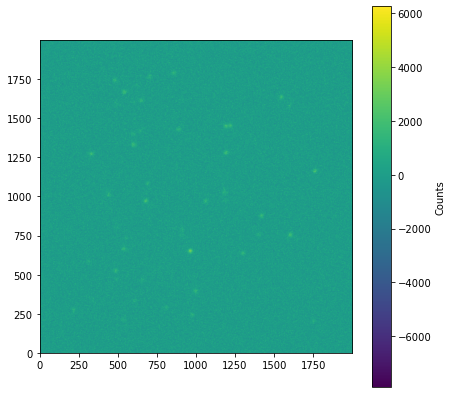

In [3]:
imagen = np.zeros([2000, 2000]) # tamaño de la imagen
ganancia = 1.0 # ganancia de la camara [electrones/segundo/píxel]
nivel_ruido = 1500 # nivel de bias

estrellas_con_ruido = imsim.stars(imagen, 50, max_counts=2000, fwhm=10) + imsim.read_noise(imagen, nivel_ruido, gain=ganancia) # genero las estrellas y el ruido

plt.figure("stars_with_noise", figsize=[7, 7])
plt.imshow(estrellas_con_ruido, vmin=np.min(estrellas_con_ruido), vmax=np.max(estrellas_con_ruido)/1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

Intentamos quitar el ruido que hemos generado restando la función de ruido que hemos generado con los mismos argumentos que hemos usado anteriormente, de tal forma que simulamos el ruido electrónico de nuestra CCD/CMOS. No obtendremos la imagen solo de estrellas: ahora tenemos incluso más ruido que antes. De hecho es mucho más difícil distinguir las estrellas en esta imagen:

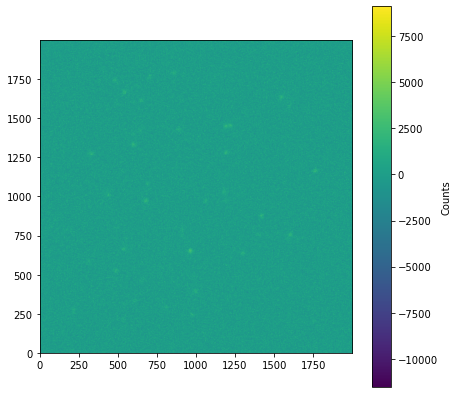

In [4]:
estrellas_menos_ruido = estrellas_con_ruido - imsim.read_noise(imagen, nivel_ruido, gain=ganancia)

plt.figure("intento_incorrecto_quitar_ruido", figsize=[7, 7])
plt.imshow(estrellas_menos_ruido, vmin=np.min(estrellas_menos_ruido), vmax=np.max(estrellas_menos_ruido)/1.2, origin='lower')
plt.colorbar(label='Counts')
plt.show()

## Cada imagen tiene ruido

Todas las imágenes, incluidas las imágenes de calibración como los *bias* y los *darks*, tienen ruido. Si intentáramos calibrar las imágenes tomando un solo *bias* y un solo *dark*, el resultado final podría empeorar.

Construimos un *bias* y *dark* con ruido y un *flat*:

In [5]:
gain = 1.0 #electrones/segundo/píxel

tiempo_estrella = 30.0 #segundos
tiempo_dark = 60.0 #segundos

dark = 0.1 #electrones/segundo/píxel

cuentas_cielo = 20 # cuentas
nivel_bias = 1100 #cuentas

ruido_lectura = 700 #electrones

cuenta_max_estrella = 2000 # cuentas maximas de estrellas

bias_con_ruido = (imsim.bias(imagen, nivel_bias, realistic=True) + 
                   imsim.read_noise(imagen, ruido_lectura, gain=gain))

dark_con_ruido = (imsim.bias(imagen, nivel_bias, realistic=True) + 
                         imsim.dark_current(imagen, dark, tiempo_dark, gain=gain, hot_pixels=True) +
                         imsim.read_noise(imagen, ruido_lectura, gain=gain))

flat = imsim.sensitivity_variations(imagen)

In [6]:
estrellas_realistas = (imsim.stars(imagen, 50, max_counts=cuenta_max_estrella) +
                   imsim.dark_current(imagen, dark, tiempo_estrella, gain=gain, hot_pixels=True) +
                   imsim.bias(imagen, nivel_bias, realistic=True) +
                   imsim.read_noise(imagen, ruido_lectura, gain=gain)
                  )

Mostramos nuestra imagen sin calibrar:

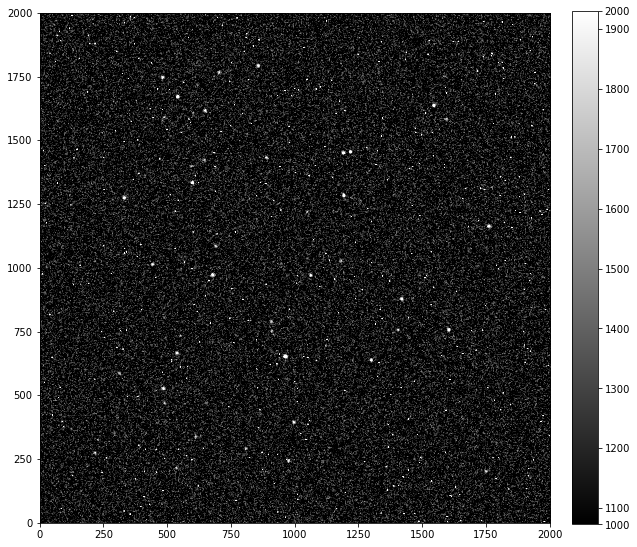

In [7]:
cf.show_image(estrellas_realistas, cmap='gray', percu=59.9)

## Calibrando la imagen

Primero calculamos la *dark current*, escalada al tiempo de exposición de nuestra imagen de luz.

In [8]:
dark_current = tiempo_estrella * (dark_con_ruido - bias_con_ruido) / tiempo_dark

A continuación, restamos el *bias* y la *dark current* de la imagen de la estrella y luego aplicamos la corrección del *flat*.

In [9]:
estrellas_calibradas = (estrellas_realistas - bias_con_ruido - dark_current) / flat

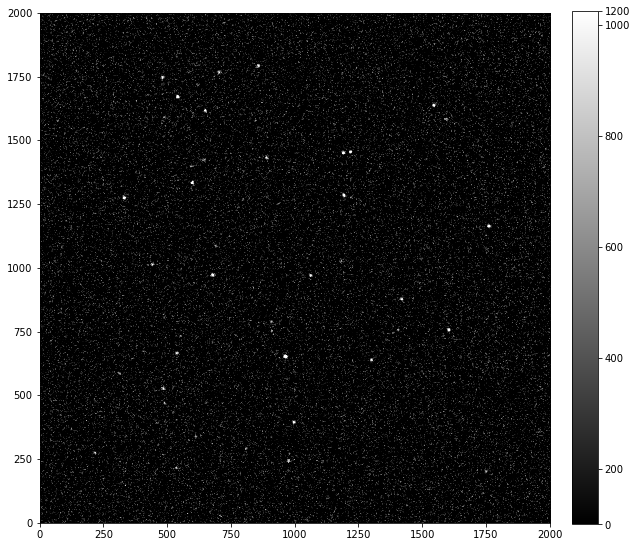

In [10]:
cf.show_image(estrellas_calibradas, cmap='gray', percu=59.9)

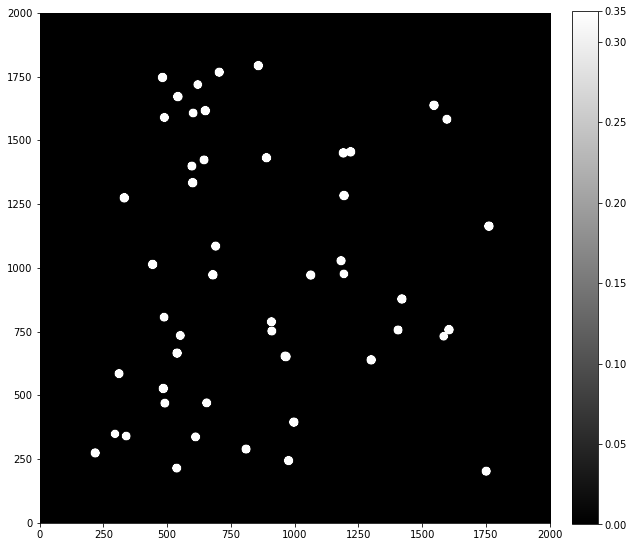

In [11]:
cf.show_image(imsim.stars(imagen, 50, max_counts=cuenta_max_estrella) , cmap='gray', percu=59.9) # mis estrellas

## Combinación de las imagenes de calibración

Cuando combinamos imágenes esperamos:

- Reducir el ruido en las imágenes.

- Eliminar artefactos transitorios como rayos cósmicos y/o satélites.

- Eliminar estrellas en flat realizados con fondo de cielo.

Es esencial que se obtengan varias tomas de cada tipo de imagen de calibración (*bias*, *dark*, *flat*). Combinarlos reduce el ruido en las imágenes en aproximadamente un factor de $\frac{1}{\sqrt{N}}$ donde $N$ es el número de imágenes que se combinan. Como hemos visto anteriormente una imagen de calibración en realidad aumenta el ruido en la imagen.

### Función ${1}/{\sqrt{N}}$

<function matplotlib.pyplot.show(close=None, block=None)>

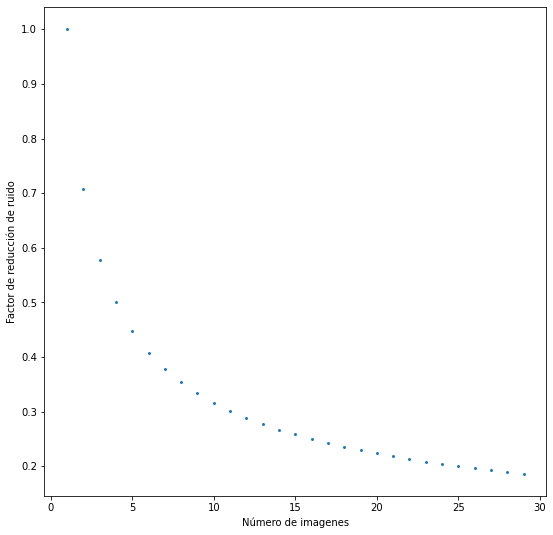

In [12]:
N=30
plt.figure(figsize=(9, 9))
plt.scatter(np.arange(1,N,1), 1/np.sqrt(np.arange(1,N,1)), s=15 ,marker = '.')
plt.xlabel('Número de imagenes')
plt.ylabel('Factor de reducción de ruido');

plt.show

## Combinando imágenes promediando, pero recortando los valores extremos

In [13]:
import os

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rc

from astropy.visualization import hist
from astropy.stats import mad_std

# Parametrons para los plots
rc('font', size=10)
rc('axes', grid=True)

# Generador de numeros aleatorios
seed = os.getenv('GUIDE_RANDOM_SEED', None)

# Generador de ruido aleatorio
noise_rng = np.random.default_rng(seed)

Vamos a ver un ejemplo con una imagen simulada como veniamos haciendo hasta ahora. Para simplificar eligiremos una distribución gaussiana. 

En imágenes *flat* bien hechas, el ruido es técnicamente una distribución de Poisson, pero con un número suficientemente grande de cuentas, la distribución es indistinguible de una distribución gaussiana cuyo ancho está relacionado con la raíz cuadrada del número de cuentas. Por lo tanto la mayor parte de la imagen estará dominada por el ruido de lectura gaussiana del detector o el ruido de Poisson del fondo del cielo.

Vamos a crear 100 distribuciones gaussianas con una media de cero y una desviación estándar de uno, y usaremos el promedio y la mediana. 

Cada distribución tiene un tamaño de de ```102400``` valores o si lo vemos como una imagen, 320 × 320 pixeles.

Podemos pensar que cada una de estas 100 distribuciones fuera una imagen. Para que la analogía con las imágenes reales sea un poco más directa, agregamos 1000 cuentas a cada distribución.

In [14]:
numero_imagenes = 100
nivel_bias = 1000
tamaño_imagen = 320

bits = noise_rng.normal(size=(numero_imagenes, tamaño_imagen**2)) + nivel_bias # estoy creando las 100 imagenes

average = np.average(bits, axis=0) # estoy apilando estas imagenes mediante la media
median = np.median(bits, axis=0) # estoy apilando estas imagenes mediante la mediana

average, median

(array([1000.04008262, 1000.06871384,  999.97549126, ...,  999.99622107,
         999.82784728, 1000.04419076]),
 array([1000.01514359, 1000.0692878 ,  999.89915437, ..., 1000.02463888,
         999.85293529, 1000.02960743]))

In [15]:
np.min(bits), np.max(bits)

(994.88382270805, 1005.6447493486861)

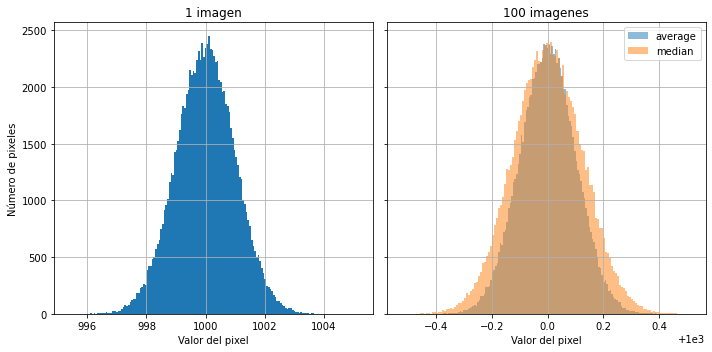

In [16]:
#%matplotlib widget
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10, 5))

hist(bits[0, :], bins='freedman', ax=ax[0]);
ax[0].set_title('1 imagen')
ax[0].set_xlabel('Valor del pixel')
ax[0].set_ylabel('Número de pixeles')
ax[0].set_xlim(np.min(bits), np.max(bits))

#hist(bits[0, :], bins='freedman', label='imagen', alpha=0.5, ax=ax[1])
hist(average, bins='freedman', label='average', alpha=0.5, ax=ax[1]);
hist(median, bins='freedman', label='median', alpha=0.5, ax=ax[1]);
ax[1].set_title('{} imagenes'.format(numero_imagenes))
ax[1].set_xlabel('Valor del pixel')
ax[1].legend()

La combinación por promedio da una distribución más estrecha (es decir, menos ruidosa) que la combinación por mediana, aunque ambas redujeron el ancho de la distribución. 

La conclusión hasta ahora es que la combinación por promedio es levemente preferible a la combinación por mediana. 


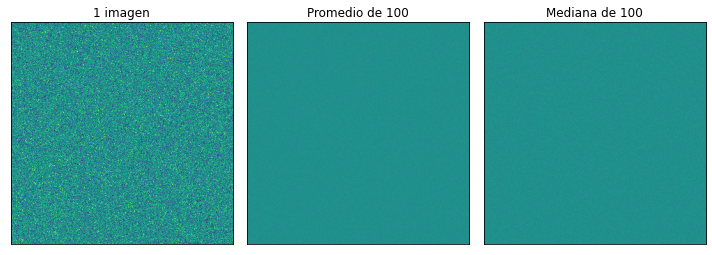

In [17]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 5))
data_source = [bits[0, :], average, median]
titles = ['1 imagen', 'Promedio de {n}'.format(n=numero_imagenes), 'Mediana de {n}'.format(n=numero_imagenes)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(tamaño_imagen, tamaño_imagen), vmin=nivel_bias - 3, vmax=nivel_bias + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)

### Ventajas de la mediana

La mediana nos va a permitir quitar las cuentas que sean muy distintas al resto, por lo que nos va a eliminar artefactos no deseados debido a rayos cósmicos por ejemplo.

Vamos a establecer 50 pixeles en los que tendremos un valor un poco más alto que el resto.

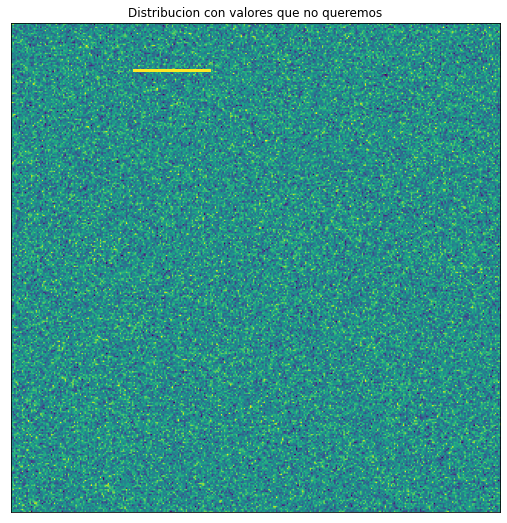

In [18]:
bits[0, 10000:10050] = 2 * nivel_bias
plt.figure(figsize=(9, 9))
plt.imshow(bits[0, :].reshape(tamaño_imagen, tamaño_imagen), vmin=nivel_bias - 3, vmax=nivel_bias + 3)
plt.xticks([])
plt.yticks([])
plt.title('Distribucion con valores que no queremos')
plt.grid(False)

Si ahora realizamos de nuevo la media y la mediana

In [19]:
average = np.average(bits, axis=0)
median = np.median(bits, axis=0)

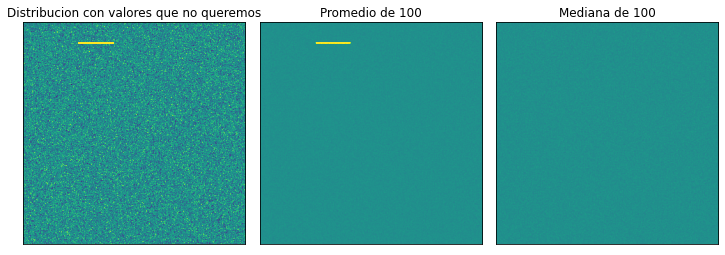

In [20]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 5))
data_source = [bits[0, :], average, median]
titles = ['Distribucion con valores que no queremos', 'Promedio de {n}'.format(n=numero_imagenes), 'Mediana de {n}'.format(n=numero_imagenes)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(tamaño_imagen, tamaño_imagen), vmin=nivel_bias - 3, vmax=nivel_bias + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)

Por un lado, las propiedades del ruido son mejores cuando se combinan tomando el promedio. Por otro lado, la mediana elimina características que aparecen en una sola imagen (aviones, rayos cósmicos, satélites...).

Las imágenes astronómicas casi siempre tendrán esas características. Incluso en una exposición muy corta, los impactos de rayos cósmicos son frecuentes.

### Mejor opción: combinar utilizando el promedio pero con MAD

[Median Absolute Deviation (Wikipedia)](https://en.wikipedia.org/wiki/Median_absolute_deviation)

La desviación absoluta mediana, o MAD, de un conjunto de puntos x se define como $MAD=\frac{1}{N}\sum_{i=0}^{i=N}|x_i−median(x)|$. 

Esta es una medida de la distancia absoluta típica desde la mediana del conjunto de valores.

In [21]:
mad_sigma = mad_std(bits, axis=0)
excluidos = (bits - median) / mad_sigma > 10 # excluyendo aquellos valores que se alejen de una distancia >10

In [22]:
valores_originales = bits[excluidos] # guardamos los valores originales
bits[excluidos] = np.nan          # ponemos un nan para no tomar estos valores en cuenta al realizar el promedio

clip_combine = np.nanmean(bits, axis=0) # realizamos el promedio sin tener en cuenta los nan
bits[excluidos] = valores_originales 

Podemos usar también la función sigma_clipped para descartar los valores que se encuentren por encima de cierta sigma.

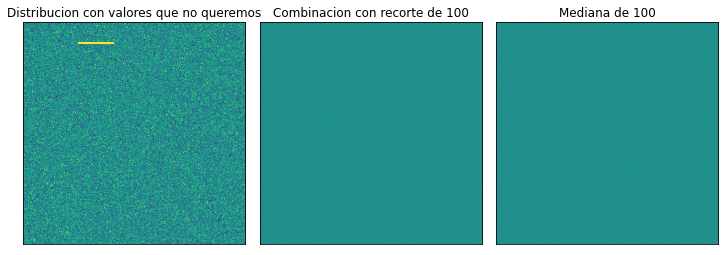

In [23]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 5))
data_source = [bits[0, :], clip_combine, median]
titles = ['Distribucion con valores que no queremos', 'Combinacion con recorte de {n}'.format(n=numero_imagenes), 'Mediana de {n}'.format(n=numero_imagenes)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(tamaño_imagen, tamaño_imagen), vmin=nivel_bias - 3, vmax=nivel_bias + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)